In [ ]:
!pip install brian2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.3 MB/s eta 0:00:00


In [ ]:
from keras.datasets import mnist
from brian2 import *
import brian2.numpy_ as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
from tensorflow.keras.datasets import mnist

# MNIST dataset (0-9)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 픽셀값(0-255)을 발화율(Hz)로 변환 (스케일 축소)
# 최대값 255가 약 63Hz가 되도록 4로 나눔
X_train = X_train / 4
X_test = X_test / 4

# 최종 데이터셋 크기 출력
X_train.shape, X_test.shape


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

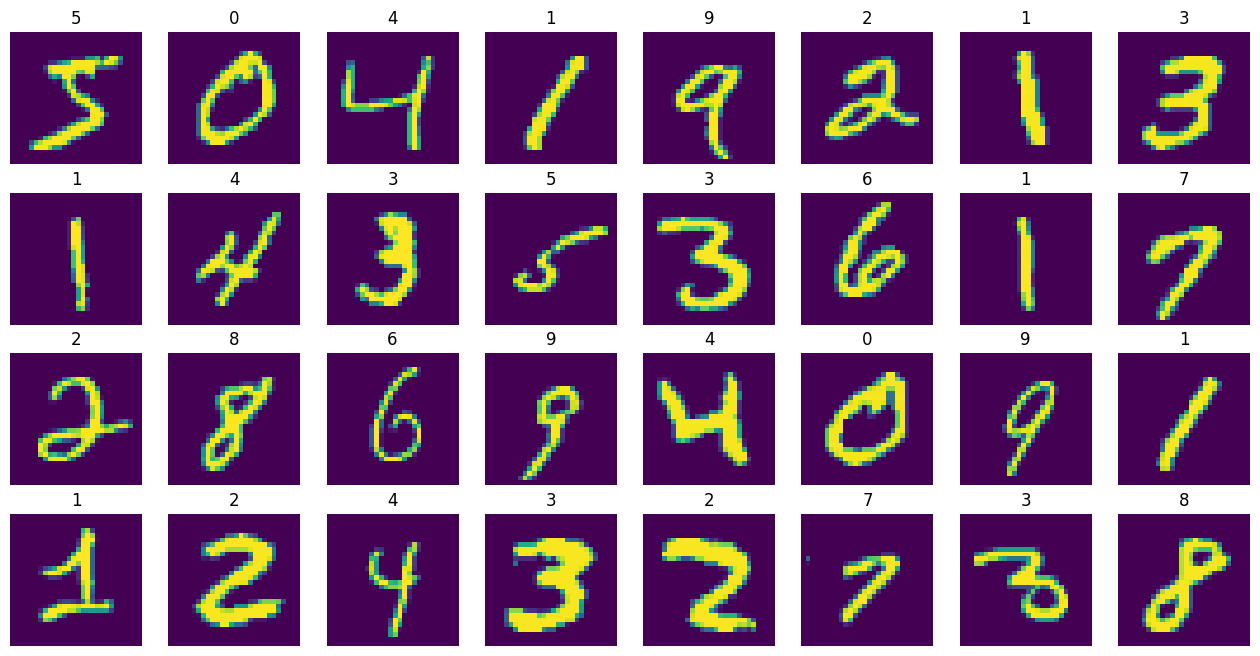

In [ ]:
plt.figure(figsize=(16,8))
for img in range(32):
    plt.subplot(4,8,1+img)
    plt.title(y_train[img])
    plt.imshow(X_train[img])
    plt.axis('off')

In [ ]:
prefs.codegen.target = 'numpy'
defaultclock.dt = 0.5*ms

# ===== 정확도 우선 상수 =====
ACTIVE_T   = 0.25*second
PASSIVE_T  = 0.05*second   # 유지
RATE_SCALE = (0.35/0.25)
CONNECT_P  = 0.60

n_input = 28*28
n_e = 100
n_i = n_e

v_rest_e, v_reset_e, v_thresh_e = -60.*mV, -65.*mV, -52.*mV
v_rest_i, v_reset_i, v_thresh_i = -60.*mV, -45.*mV, -40.*mV

taupre = 20*ms
taupost = taupre
gmax = .05
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre  *= gmax

stdp = '''w : 1
    lr : 1 (shared)
    dApre/dt  = -Apre  / taupre  : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''

pre = '''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''

post = '''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''

class Model():
    def __init__(self, debug=False):
        app = {}

        # 입력: PoissonGroup
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')

        # 흥분성
        neuron_e = '''
            dv/dt  = (ge*(0*mV - v) + gi*(-100*mV - v) + (v_rest_e - v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms)  : 1
            dgi/dt = -gi / (10*ms) : 1
        '''
        app['EG'] = NeuronGroup(
            n_e, neuron_e, threshold='v>v_thresh_e',
            refractory=5*ms, reset='v=v_reset_e', method='euler', name='EG'
        )
        app['EG'].v = v_rest_e - 20.*mV

        # 억제성
        neuron_i = '''
            dv/dt  = (ge*(0*mV - v) + (v_rest_i - v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
        '''
        app['IG'] = NeuronGroup(
            n_i, neuron_i, threshold='v>v_thresh_i',
            refractory=2*ms, reset='v=v_reset_i', method='euler', name='IG'
        )
        app['IG'].v = v_rest_i - 20.*mV

        # 입력→흥분성 (STDP, 연결 확률 ↑)
        app['S1'] = Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect(p=CONNECT_P)
        app['S1'].w = 'rand()*gmax'
        app['S1'].lr = 1

        # 흥분성→억제성 (1:1)
        app['S2'] = Synapses(app['EG'], app['IG'], 'w:1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = 3

        # 억제성→흥분성 (자가 제외)
        app['S3'] = Synapses(app['IG'], app['EG'], 'w:1', on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app['S3'].w = .03

        # 평가용 스파이크 모니터(재사용)
        app['SPK_E'] = SpikeMonitor(app['EG'], name='SPK_E')

        self.net = Network(app.values())
        self.net.run(0*second)

    def __getitem__(self, key):
        return self.net[key]

    def train(self, X, epoch=1):
        self.net['S1'].lr = 1
        for _ in range(epoch):
            for idx in range(len(X)):
                self.net['PG'].rates = (X[idx].ravel() * RATE_SCALE) * Hz
                self.net.run(ACTIVE_T)
                self.net['PG'].rates = np.zeros(n_input)*Hz
                self.net.run(PASSIVE_T)

    def evaluate(self, X):
        self.net['S1'].lr = 0
        feats = []
        spkmon = self.net['SPK_E']
        for idx in range(len(X)):
            i0 = len(spkmon.i)
            self.net['PG'].rates = (X[idx].ravel()) * Hz
            self.net.run(ACTIVE_T)
            inds = np.array(spkmon.i[i0:])
            counts = np.bincount(inds, minlength=n_e)
            feats.append(counts.astype(np.int16))
            self.net['PG'].rates = np.zeros(n_input)*Hz
            self.net.run(PASSIVE_T)
        return feats


In [ ]:
from tqdm.auto import tqdm
import numpy as np, random
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# --- 정확도 우선 모드 기본값 ---
ACCURATE_ACTIVE_T  = 0.25*second     # 0.15 → 0.25
ACCURATE_PASSIVE_T = 0.05*second     # 유지
ACCURATE_RATE_SCALE = (0.35/0.25)    # ≈1.4 : 총 스파이크량 보정

def train_with_progress(model, X, epoch=1,
                        active_t=ACCURATE_ACTIVE_T,
                        passive_t=ACCURATE_PASSIVE_T,
                        rate_scale=ACCURATE_RATE_SCALE):
    """
    정확도 우선 학습:
    - 노출 시간 늘림 + 완만한 rate 보정
    - tqdm 진행바 표시
    """
    model.net['S1'].lr = 1  # STDP ON
    total = epoch * len(X)
    pbar = tqdm(total=total, desc="STDP train", unit="img")
    for _ in range(epoch):
        for idx in range(len(X)):
            model.net['PG'].rates = (X[idx].ravel() * rate_scale) * Hz  # Active
            model.net.run(active_t)

            model.net['PG'].rates = np.zeros(n_input) * Hz              # Passive
            model.net.run(passive_t)

            pbar.update(1)
    pbar.close()

def evaluate_with_progress(model, X, desc="Feature extract",
                           active_t=ACCURATE_ACTIVE_T,
                           passive_t=ACCURATE_PASSIVE_T):
    """
    정확도 우선 평가:
    - STDP OFF
    - SpikeMonitor 재사용(SPK_E), 증분 카운트
    """
    model.net['S1'].lr = 0
    feats = []
    pbar = tqdm(total=len(X), desc=desc, unit="img")

    spkmon = model.net['SPK_E']  # Model.__init__에서 생성된 모니터

    for idx in range(len(X)):
        i0 = len(spkmon.i)

        model.net['PG'].rates = (X[idx].ravel()) * Hz
        model.net.run(active_t)

        inds = np.array(spkmon.i[i0:])
        counts = np.bincount(inds, minlength=n_e)
        feats.append(counts.astype(np.int32))

        model.net['PG'].rates = np.zeros(n_input) * Hz
        model.net.run(passive_t)

        pbar.update(1)
    pbar.close()
    return np.vstack(feats)

def test1_progress(train_items=8000, assign_items=3000, eval_items=2000,
                   epoch=1):
    # 재현성
    np.random.seed(0); random.seed(0)

    model = Model()  # 정확도 우선은 CONNECT_P를 0.5~1.0으로 두면 더 좋음(모델 정의부에서 조정)

    # STDP 학습 (시간 늘려서)
    train_with_progress(model, X_train[:train_items], epoch=epoch)

    # 스냅샷
    model.net.store('train', 'train.b2')

    # 학습 특징 추출
    f_train = evaluate_with_progress(model, X_train[:assign_items], desc="Feat (train)")

    # 특징 스케일링 + RF 강화
    scaler = StandardScaler(with_mean=True, with_std=True)
    f_train_std = scaler.fit_transform(f_train)

    clf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,          # 제한 해제
        max_features='sqrt',
        n_jobs=-1,
        random_state=0
    )
    clf.fit(f_train_std, y_train[:assign_items])
    print("Train feature accuracy:", clf.score(f_train_std, y_train[:assign_items]))

    # 테스트 특징 추출
    f_test  = evaluate_with_progress(model, X_test[:eval_items], desc="Feat (test)")
    f_test_std = scaler.transform(f_test)

    # 예측/지표
    y_pred = clf.predict(f_test_std)
    acc = accuracy_score(y_test[:eval_items], y_pred)
    cm  = confusion_matrix(y_test[:eval_items], y_pred)

    print("Test accuracy:", acc)
    print("Confusion matrix:\n", cm)
    return acc, cm, y_pred, eval_items

# 실행
acc, cm, y_pred, eval_items = test1_progress()


STDP train:   0%|          | 0/8000 [00:00<?, ?img/s]

Feat (train):   0%|          | 0/3000 [00:00<?, ?img/s]

Train feature accuracy: 1.0


Feat (test):   0%|          | 0/2000 [00:00<?, ?img/s]

Test accuracy: 0.74
Confusion matrix:
 [[155   0   1   2   3   6   7   0   0   1]
 [  0 228   1   0   0   0   0   0   4   1]
 [  4  16 161   4   7   2   8   8   8   1]
 [  4   4   3 159   4  12   3   9   5   4]
 [  0   5   2   1 178   0   7   6   1  17]
 [ 12   4   1  25  12  94   4  11  10   6]
 [  9   4   2   0  17   6 135   0   5   0]
 [  0  14   6   1  11   0   2 149   7  15]
 [  7  15  10  36   8   5   7   3  93   8]
 [  2   4   0   4  32   0   1  19   4 128]]
